In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import pandas

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [3]:
transoforms = tv.transforms.Compose([tv.transforms.Grayscale(3), tv.transforms.Resize((224, 224)), tv.transforms.ToTensor()])
Batch_size = 200
Lr = 0.001
loss = torch.nn.CrossEntropyLoss(reduction='sum')

Data_train = tv.datasets.EMNIST('.', split='mnist', train=True, download=True, transform=transoforms)
Data_test = tv.datasets.EMNIST('.', split='mnist', train=False, download=True, transform=transoforms)

Train = torch.utils.data.DataLoader(Data_train, batch_size=Batch_size, shuffle=True)
Test = torch.utils.data.DataLoader(Data_test, batch_size=Batch_size)

In [4]:
Data_train

Dataset EMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Посмотрим, с какими данными мы имеем дело

In [5]:
Data_train[0][0].shape

torch.Size([3, 224, 224])

In [6]:
print(*Data_test.classes)

0 1 2 3 4 5 6 7 8 9


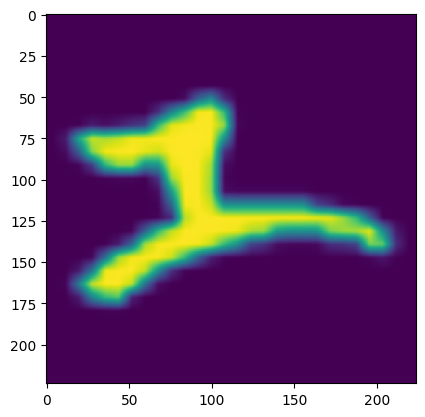

In [7]:
plt.imshow(Data_train[2][0][0].squeeze())

Посмотрим на распределение классов в обучающем и тестовом датасетах

In [8]:
def class_analysis(dataset):
    res = dict()
    for X, Y in dataset:
        if Y in res:
            res[Y] += 1            
        else:
            res[Y] = 1
    print(f'Количество классов в датасете {len(res)}')
    plt.bar(res.keys(), res.values())
    plt.title('Распределение классов в датасете')
    plt.show()

Количество классов в датасете 10


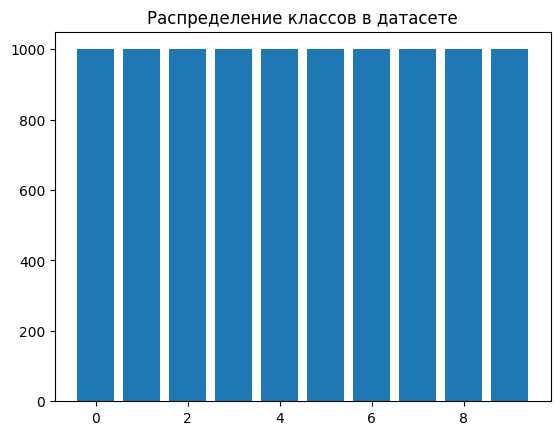

In [9]:
class_analysis(Data_test)

Количество классов в датасете 10


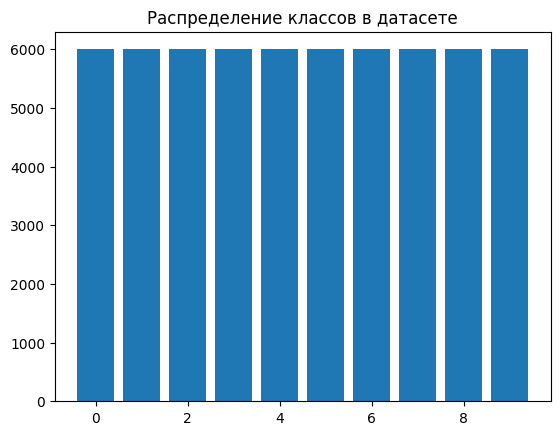

In [10]:
class_analysis(Data_train)

Все классы используются, их распределение равномерное, это хорошо скажется на обучении нейросетей

## Нейросетевые модели

In [52]:
def train(model, train_iter, test_iter, trainer, model_name, epoch_num=10, plot=True, verbose=False):

    hist_train = np.empty(epoch_num)
    hist_test = np.empty(epoch_num)
    acc_train = np.empty(epoch_num)
    acc_test = np.empty(epoch_num)
        
    model.to(device)  
        
    for epoch in range(epoch_num):
        start = time.time()
        hist_train_epoch = 0
        acc_train_epoch = 0
        n = 0
        model.train()
        for i, (X, Y) in enumerate(train_iter):
            X, Y = X.to(device), Y.to(device)
            trainer.zero_grad()
            if model_name == 'Inception v3':
                y_hat, __ = model(X)
            else:
                y_hat = model(X)
            l = loss(y_hat, Y)
            l.backward()
            trainer.step()
            hist_train_epoch += l.item()
            acc_train_epoch += (y_hat.argmax(axis=1) == Y).sum().item()
            n += Y.shape[0]

            if verbose:
                print(f'Done {i} of {len(train_iter)} in train epoch {epoch}', end='\r')
                
        hist_train[epoch] = hist_train_epoch/n
        acc_train[epoch] = acc_train_epoch/n*100
        
        model.eval()
        hist_test_epoch = 0
        acc_test_epoch = 0
        n = 0
        for i, (X, Y) in enumerate(test_iter):
            X, Y = X.to(device), Y.to(device)
            y_hat = model(X)
            l = loss(y_hat, Y)
            hist_test_epoch += l.item()
            acc_test_epoch += (y_hat.argmax(axis=1) == Y).sum().item()
            n += Y.shape[0]
            
            if verbose:
                print(f'Done {i} of {len(test_iter)} in test epoch {epoch}', end='\r')
                
        hist_test[epoch] = hist_test_epoch/n
        acc_test[epoch] = acc_test_epoch/n*100
        
        if verbose:
            print(f'Выполнена эпоха - {epoch} за {time.time() - start} с,  Результаты: \n Loss -- {hist_train[epoch]}/{hist_test[epoch]}, Acc -- {acc_train[epoch]}/{acc_test[epoch]}')
            
    if plot:
        plt.subplot(1, 2, 1)
        plt.plot(hist_test, label='Loss test')
        plt.plot(hist_train, label='Loss train')
        plt.legend()
        plt.title(f'Loss {model_name}')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(acc_test, label='Acc test, %')
        plt.plot(acc_train, label='Acc train, %')
        plt.legend()
        plt.title(f'Accuracy {model_name}')
        plt.grid()

        plt.show()

    return (hist_train, hist_test, acc_train, acc_test)

### ResNet 18

In [12]:
model_resnet18 = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_resnet18.parameters():
    param.requires_grad = False

model_resnet18.fc = torch.nn.Linear(512, 10)

print("Params to learn:")
params_to_update = []
for name, param in model_resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_resnet18 = torch.optim.Adam(params_to_update, lr=Lr)


Params to learn:
	 fc.weight
	 fc.bias


In [13]:
summary(model_resnet18.to(device), input_size=next(iter(Train))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Выполнена эпоха - 0 за 108.45090579986572 с,  Результаты: 
 Loss -- 0.5503697188695272/0.24238343544006347, Acc -- 87.92166666666667/94.59
Выполнена эпоха - 1 за 111.55107641220093 с,  Результаты: 
 Loss -- 0.20232642679214477/0.1679310188293457, Acc -- 95.25333333333333/95.84
Выполнена эпоха - 2 за 113.20913076400757 с,  Результаты: 
 Loss -- 0.15611994692484538/0.14154760332107544, Acc -- 96.02833333333334/96.15
Выполнена эпоха - 3 за 112.76161456108093 с,  Результаты: 
 Loss -- 0.13421223441759744/0.12228513841629028, Acc -- 96.45333333333333/96.72
Выполнена эпоха - 4 за 114.09201049804688 с,  Результаты: 
 Loss -- 0.1191706166903178/0.1148704363822937, Acc -- 96.77833333333334/96.77
Выполнена эпоха - 5 за 113.14746284484863 с,  Результаты: 
 Loss -- 0.11138010110855102/0.10753343057632446, Acc -- 96.91833333333332/97.00999999999999
Выполнена эпоха - 6 за 112.10475754737854 с,  Результаты: 
 Loss -- 0.10338507910569508/0.10198256788253784, Acc -- 97.13666666666667/97.08
Выполнена эп

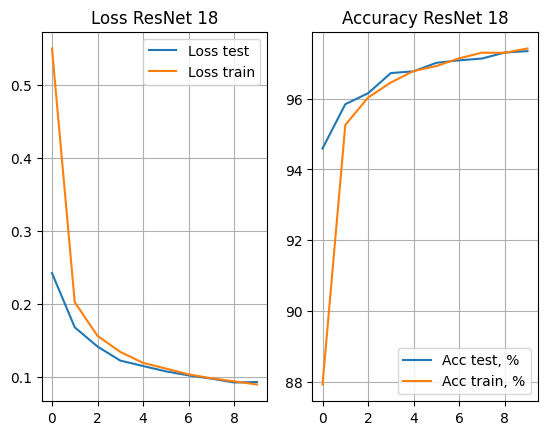

In [14]:
resnet18 = train(model_resnet18, Train, Test, optimizer_resnet18, 'ResNet 18', verbose=True)

### VGG 16

In [15]:
model_VGG16 = tv.models.vgg16(weights=tv.models.VGG16_Weights.IMAGENET1K_V1)

for param in model_VGG16.parameters():
    param.requires_grad = False

model_VGG16.classifier[6] = torch.nn.Linear(4096, 10)

print("Params to learn:")
params_to_update = []
for name, param in model_VGG16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_VGG16 = torch.optim.Adam(params_to_update, lr=Lr)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [16]:
summary(model_VGG16.to(device), input_size=next(iter(Train))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Выполнена эпоха - 0 за 1762.8894209861755 с,  Результаты: 
 Loss -- 0.5728535868962605/0.27406273880004883, Acc -- 83.24666666666667/93.58999999999999
Выполнена эпоха - 1 за 1764.0443723201752 с,  Результаты: 
 Loss -- 0.3450434763590495/0.20988487300872802, Acc -- 89.19/95.0
Выполнена эпоха - 2 за 1760.034377336502 с,  Результаты: 
 Loss -- 0.31255960311889647/0.18291419124603273, Acc -- 90.11666666666667/95.46
Выполнена эпоха - 3 за 1759.2396521568298 с,  Результаты: 
 Loss -- 0.29605956602096556/0.1696590705871582, Acc -- 90.47333333333333/95.66
Выполнена эпоха - 4 за 1758.6979513168335 с,  Результаты: 
 Loss -- 0.2911717977523804/0.1605613166809082, Acc -- 90.62333333333333/96.00999999999999
Выполнена эпоха - 5 за 1758.9509551525116 с,  Результаты: 
 Loss -- 0.2788597127596537/0.15668104705810548, Acc -- 90.96/95.86
Выполнена эпоха - 6 за 1758.7215404510498 с,  Результаты: 
 Loss -- 0.2755231875101725/0.14326665306091307, Acc -- 91.10333333333334/96.43
Выполнена эпоха - 7 за 1758.9

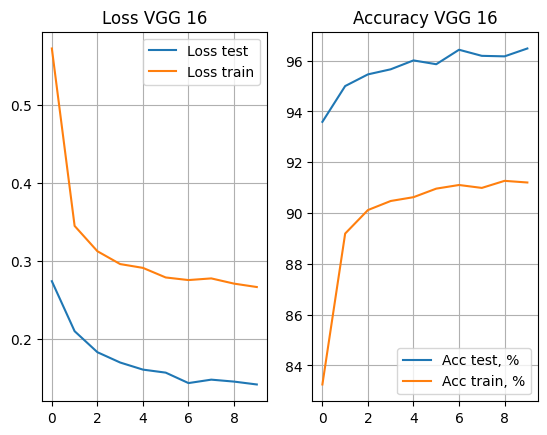

In [17]:
VGG16 = train(model_VGG16, Train, Test, optimizer_VGG16, 'VGG 16', verbose=True)

### Inception V3

In [47]:
transoforms_inseption = tv.transforms.Compose([tv.transforms.Grayscale(3), tv.transforms.Resize((299, 299)), tv.transforms.ToTensor()])

Data_train_inseption = tv.datasets.EMNIST('.', split='mnist', train=True, download=True, transform=transoforms_inseption)
Data_test_inseption = tv.datasets.EMNIST('.', split='mnist', train=False, download=True, transform=transoforms_inseption)

Train_inseption = torch.utils.data.DataLoader(Data_train_inseption, batch_size=Batch_size, shuffle=True)
Test_inseption = torch.utils.data.DataLoader(Data_test_inseption, batch_size=Batch_size)

model_inception_v3 = tv.models.inception.inception_v3(weights=tv.models.inception.Inception_V3_Weights.IMAGENET1K_V1)

for param in model_inception_v3.parameters():
    param.requires_grad = False

model_inception_v3.fc = torch.nn.Linear(2048, 10)

print("Params to learn:")
params_to_update = []
for name, param in model_inception_v3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_inception_v3 = torch.optim.Adam(params_to_update, lr=Lr)

Params to learn:
	 fc.weight
	 fc.bias


In [48]:
summary(model_inception_v3.to(device), input_size=next(iter(Train_inseption))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Выполнена эпоха - 0 за 937.9819619655609 с,  Результаты: 
 Loss -- 0.48768609860738116/0.3513542667388916, Acc -- 85.12666666666667/90.52
Выполнена эпоха - 1 за 958.8488023281097 с,  Результаты: 
 Loss -- 0.4341754568099976/0.31115887832641603, Acc -- 86.25666666666667/91.22
Выполнена эпоха - 2 за 966.837887763977 с,  Результаты: 
 Loss -- 0.41213519630432127/0.2808143486022949, Acc -- 86.70333333333333/91.81
Выполнена эпоха - 3 за 946.1446542739868 с,  Результаты: 
 Loss -- 0.4015678404490153/0.2713880939483643, Acc -- 86.76333333333334/92.19000000000001
Выполнена эпоха - 4 за 945.6981227397919 с,  Результаты: 
 Loss -- 0.3919546895345052/0.26245666732788087, Acc -- 87.105/92.05
Выполнена эпоха - 5 за 939.9307203292847 с,  Результаты: 
 Loss -- 0.3892927059173584/0.25083454666137694, Acc -- 87.09/92.65
Выполнена эпоха - 6 за 941.0877211093903 с,  Результаты: 
 Loss -- 0.38498229128519695/0.24480083656311036, Acc -- 87.22166666666666/92.62
Выполнена эпоха - 7 за 946.2646646499634 с,  Р

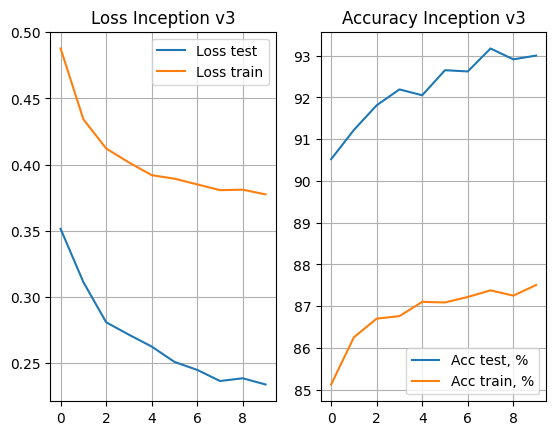

In [53]:
inception_v3 = train(model_inception_v3, Train_inseption, Test_inseption, optimizer_inception_v3, 'Inception v3', verbose=True)

### Densenet 161

In [54]:
model_Densenet_161 = tv.models.densenet.densenet161(weights=tv.models.densenet.DenseNet161_Weights.IMAGENET1K_V1)

for param in model_Densenet_161.parameters():
    param.requires_grad = False

model_Densenet_161.classifier = torch.nn.Linear(2208, 10)

print("Params to learn:")
params_to_update = []
for name, param in model_Densenet_161.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_Densenet_161 = torch.optim.Adam(params_to_update, lr=Lr)

Params to learn:
	 classifier.weight
	 classifier.bias


Выполнена эпоха - 0 за 1153.4450397491455 с,  Результаты: 
 Loss -- 0.5187283827463786/0.23707752227783202, Acc -- 88.24499999999999/94.83
Выполнена эпоха - 1 за 1193.4816138744354 с,  Результаты: 
 Loss -- 0.2002346829732259/0.16848515129089356, Acc -- 95.11833333333334/95.92
Выполнена эпоха - 2 за 1218.4521477222443 с,  Результаты: 
 Loss -- 0.15129339785575865/0.13993748035430909, Acc -- 96.13833333333334/96.3
Выполнена эпоха - 3 за 1165.583081960678 с,  Результаты: 
 Loss -- 0.1277143230756124/0.12434443206787109, Acc -- 96.56833333333333/96.58
Выполнена эпоха - 4 за 1157.2274136543274 с,  Результаты: 
 Loss -- 0.11285385476748148/0.11507973852157592, Acc -- 96.96333333333334/96.72
Выполнена эпоха - 5 за 1155.3611550331116 с,  Результаты: 
 Loss -- 0.10221453386942546/0.10972934312820434, Acc -- 97.21166666666666/96.77
Выполнена эпоха - 6 за 1172.163075208664 с,  Результаты: 
 Loss -- 0.09472866494655609/0.10138132228851318, Acc -- 97.395/96.95
Выполнена эпоха - 7 за 1163.710909605

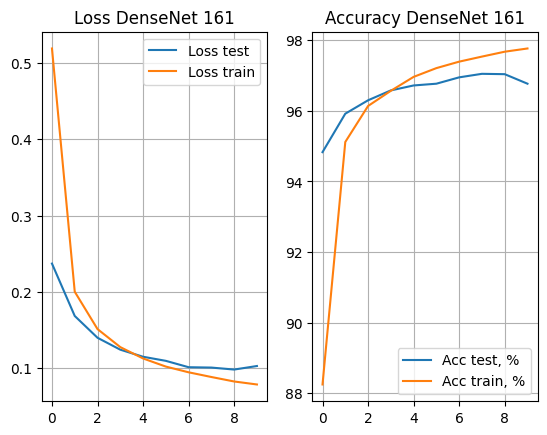

In [55]:
Densenet_161 = train(model_Densenet_161, Train, Test, optimizer_Densenet_161, 'DenseNet 161', verbose=True)

## Итоги

In [80]:
table_data = [['ResNet 18', *[row[-1] for row in resnet18]],
             ['VGG 16', *[row[-1] for row in VGG16]],
             ['Inception v3', *[row[-1] for row in inception_v3]],
             ['DenseNet 161', *[row[-1] for row in Densenet_161]]]

columns = ['Модель', 'Loss train', 'Loss test', 'Accuracy train', 'Accuracy test']

df = pandas.DataFrame(table_data, columns=columns)
print(df)

         Модель  Loss train  Loss test  Accuracy train  Accuracy test
0     ResNet 18    0.089531   0.092931       97.415000          97.34
1        VGG 16    0.266579   0.141474       91.201667          96.48
2  Inception v3    0.377452   0.233786       87.508333          93.00
3  DenseNet 161    0.078782   0.102954       97.768333          96.77


Среди выбранных моделей наилучшие результаты показали ResNet 18 и DenseNet 161. Отметим, что Inception v3, вероятно, могла бы обучиться дальше, в то время как DenseNet уже показывает признаки переобучения. Для такой простой задачи наилучшим выобором было бы использовать именно ResNet, так как данная модель легче, обучается быстрее, и показывает хорошие результаты на таких данных